# Linear Regression

I'm downloading a medical dataset from kaggle which contains verified historical data, consisting of the information and the actual medical charges. My main goal here is to create a linear regression model to predict the annual medical expenditure of the smoking and the non smoking people.

In [1]:
medical_charges_url = 'https://raw.githubusercontent.com/JovianML/opendatasets/master/data/medical-charges.csv'

In [2]:
from urllib.request import urlretrieve
urlretrieve(medical_charges_url, 'medical.csv')

('medical.csv', <http.client.HTTPMessage at 0x7f90a8cb4610>)

In [ ]:
!pip install pandas --quiet

In [3]:
import pandas as pd
medical_df = pd.read_csv('medical.csv')
medical_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


The dataset contains 1338 rows and 7 columns. Each row of the dataset contains information about one customer. 

Our objective is to find a way to estimate the value in the "charges" column using the values in the other columns. If we can do so for the historical data, then we should able to estimate charges for new customers too, simply by asking for information like their age, sex, BMI, no. of children, smoking habits and region.

In [4]:
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
medical_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## Exploratory Analysis and Visualization

In [6]:
!pip install plotly matplotlib seaborn --quiet

In [7]:
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


### First I'll visualize the Age column.

In [8]:
fig = px.histogram(medical_df, 
                   x='age', 
                   marginal='box', 
                   nbins=47, 
                   title='Distribution of Age')
fig.update_layout(bargap=0.1)
fig.show()

The distribution of ages in the dataset is almost uniform, with 20-30 customers at every age, except for the ages 18 and 19, which seem to have over twice as many customers as other ages.

### Body Mass Index
Let's look at the distribution of BMI

In [9]:
fig = px.histogram(medical_df, 
                   x='bmi', 
                   marginal='box', 
                   color_discrete_sequence=['red'], 
                   title='Distribution of BMI (Body Mass Index)')
fig.update_layout(bargap=0.1)
fig.show()

The measurements of body mass index seem to form a Gaussian distribution centered around the value 30, with a few outliers towards the right.

### Charges

Let's visualize the distribution of "charges" i.e. the annual medical charges for customers. This is the column we're trying to predict.

In [10]:
fig = px.histogram(medical_df, 
                   x='charges', 
                   marginal='box', 
                   color='smoker', 
                   color_discrete_sequence=['green', 'grey'], 
                   title='Annual Medical Charges')
fig.update_layout(bargap=0.1)
fig.show()

I can make the following observations from the above graph:

* For most customers, the annual medical charges are under \\$10,000. Only a small fraction of customer have higher medical expenses, possibly due to accidents, major illnesses and genetic diseases. The distribution follows a "power law"
* There is a significant difference in medical expenses between smokers and non-smokers. While the median for non-smokers is \\$7300, the median for smokers is close to \\$35,000.



### Age and Charges

Let's visualize the relationship between "age" and "charges" using a scatter plot. Each point in the scatter plot represents one customer. We'll also use values in the "smoker" column to color the points.

In [11]:
fig = px.scatter(medical_df, 
                 x='age', 
                 y='charges', 
                 color='smoker', 
                 opacity=0.8, 
                 hover_data=['sex'], 
                 title='Age vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

The general trend seems to be that medical charges increase with age, as we might expect. However, there is significant variation at every age, and it's clear that age alone cannot be used to accurately determine medical charges.

### BMI and Charges

In [12]:
fig = px.scatter(medical_df, 
                 x='bmi', 
                 y='charges', 
                 color='smoker', 
                 opacity=0.8, 
                 hover_data=['sex'], 
                 title='BMI vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

It appears that for non-smokers, an increase in BMI doesn't seem to be related to an increase in medical charges. However, medical charges seem to be significantly higher for smokers with a BMI greater than 30.

### Correlation

I'll try and find out the correlation between various columns comparing it with the charges.

In [13]:
medical_df.charges.corr(medical_df.age)

0.2990081933306476

In [14]:
medical_df.charges.corr(medical_df.bmi)

0.19834096883362895

To compute the correlation for categorical columns, they must first be converted into numeric columns.

In [15]:
smoker_values = {'no': 0, 'yes': 1}
smoker_numeric = medical_df.smoker.map(smoker_values)
medical_df.charges.corr(smoker_numeric)

0.787251430498478

In [16]:
medical_df.corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


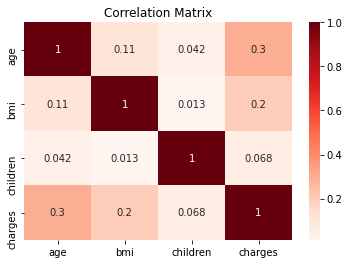

In [17]:
sns.heatmap(medical_df.corr(), cmap='Reds', annot=True)
plt.title('Correlation Matrix');

## Linear Regression using a Single Feature

I'll first try and create a data frame containing only the data for non smokers.

In [18]:
non_smoker_df = medical_df[medical_df.smoker == 'no']

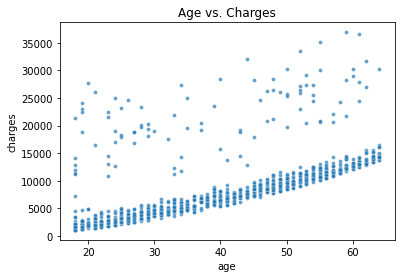

In [19]:
plt.title('Age vs. Charges')
sns.scatterplot(data=non_smoker_df, x='age', y='charges', alpha=0.7, s=15);

In [20]:
!pip install scikit-learn --quiet

In [21]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [22]:
inputs = non_smoker_df[['age']]
targets = non_smoker_df.charges
print('inputs.shape :', inputs.shape)
print('targes.shape :', targets.shape)

inputs.shape : (1064, 1)
targes.shape : (1064,)


In [23]:
model.fit(inputs, targets)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

I'll try and predict charges for random ages.

In [25]:
!pip install numpy --quiet
import numpy as np

In [26]:
model.predict(np.array([[23], 
                        [37], 
                        [61]]))

array([ 4055.30443855,  7796.78921819, 14210.76312614])

Let compute the predictions for the entire set of inputs


In [27]:
predictions = model.predict(inputs)
predictions

array([2719.0598744 , 5391.54900271, 6727.79356686, ..., 2719.0598744 ,
       2719.0598744 , 3520.80661289])


Let's compute the RMSE loss to evaluate the model.

In [30]:
def rmse(targets, predictions):
    return np.sqrt(np.mean(np.square(targets - predictions)))

In [31]:
rmse(targets, predictions)


4662.505766636391

It seems like my prediction is off by $4000 on average, which is not too bad considering the fact that there are several outliers.

In [36]:
def estimate_charges(age, w, b):
    return w * age + b

In [37]:
def try_parameters(w, b):
    ages = non_smoker_df.age
    target = non_smoker_df.charges
    predictions = estimate_charges(ages, w, b)
    
    plt.plot(ages, predictions, 'r', alpha=0.9);
    plt.scatter(ages, target, s=8,alpha=0.8);
    plt.xlabel('Age');
    plt.ylabel('Charges')
    plt.legend(['Prediction', 'Actual']);
    
    loss = rmse(target, predictions)
    print("RMSE Loss: ", loss)

RMSE Loss:  4662.505766636391


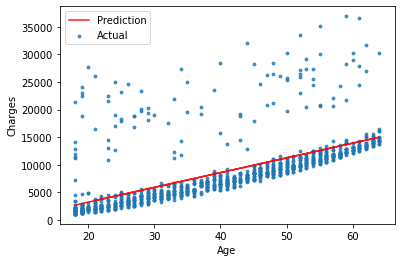

In [38]:
try_parameters(model.coef_, model.intercept_)

The line is quite close to the points. It is slightly above the cluster of points, because it's also trying to account for the outliers. 

Now I'll try to build a simple machine learning model using scikit-learn

In [39]:
inputs, targets = non_smoker_df[['age']], non_smoker_df['charges']

model = LinearRegression().fit(inputs, targets)

predictions = model.predict(inputs)

loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 4662.505766636391
